In [3]:
####
import sys
sys.path.append('../')

import aplpy
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from scipy import ndimage
from scipy.ndimage.morphology import binary_dilation, binary_closing

#FROM GITHUB
import moments
import smooth_3d
import regrid_3d

#CAREFUL!
import warnings
warnings.filterwarnings('ignore')

aplpy.__version__

#NEW
import masks

aplpy.__version__, matplotlib.matplotlib_fname()

('1.1.1',
 '/Users/ashleybarnes/github/data_cube_analysis/examples/matplotlibrc')

In [4]:
inputfile = './cube.fits'

rms_velo = [[30, 35], [35, 40]] #not case here, but can add velocity ranges either side of line
mom_velo = [40, 70] #check spectral to choose velocity range

In [5]:
# MAKE MOM maps, ERR, and MASK
cube = moments.get_cube(inputfile)
rms = moments.get_rms(cube, rms_velo)
mask = masks.get_expmask(cube, rms)

In [6]:
# bmaj = cube.header['BMAJ']
# bmin = cube.header['BMIN']
# pix = np.absolute(cube.header['CDELT1'])
# bmajp = bmaj/pix
# bminp = bmin/pix
# bareap = np.pi*bmajp*bminp
# rad = np.floor(bmajp/2)

# structure = masks.get_circmask(radius=rad)

In [7]:
# mask_l_, _ = moments.get_threshmask(cube, rms.data, thresh=2)
# mask_h_, _ = moments.get_threshmask(cube, rms.data, thresh=5)

# mask_l = mask_l_.include()
# mask_h = mask_h_.include()

# mask_d = binary_dilation(mask_h, iterations=-1, mask=mask_l)
# mask_dc = binary_closing(mask_d, structure=structure, iterations=1)
# mask_dcc = masks.get_prunemask(mask_dc, thresh=bareap*2)



In [8]:
cube_masked = cube.with_mask(mask)

mom = moments.get_momentmaps(cube_masked, 
                             mom_velocity=mom_velo,
                             moments=['mom0', 'max'])
mom0_hdu = mom['mom0'].hdu
nchan = moments.get_nchanbool(mask)

cdelt = np.absolute(cube.header['CDELT3'])
mom0err_hdu = moments.get_mom0err(nchan, rms, cdelt)

s2n_data = np.array(mom['mom0'])/mom0err_hdu.data
ids = np.isnan(s2n_data)
s2n_data[ids] = 0
s2n_hdu = fits.PrimaryHDU(s2n_data, rms.header)

maxs2n_data = np.array(mom['max'])/rms.data
maxs2n_hdu = fits.PrimaryHDU(maxs2n_data, rms.header)

In [9]:
#Mask rms = 0 values 
ids = np.where(rms.data<0)
rms.data[ids] = np.nan
mom0_hdu.data[ids] = np.nan
mom0err_hdu.data[ids] = np.nan
s2n_hdu.data[ids] = np.nan

In [10]:
# WRITE MOM maps and ERR
rms_out = 'rms_expmask.fits'
mom0_out = 'mom0_expmask.fits'
mom0err_out = 'mom0err_expmask.fits'
s2n_out ='mom0s2n_expmask.fits'

rms.writeto(rms_out, overwrite=True)
mom0_hdu.writeto(mom0_out, overwrite=True)
mom0err_hdu.writeto(mom0err_out, overwrite=True)
s2n_hdu.writeto(s2n_out, overwrite=True)

INFO: Auto-setting vmin to  9.687e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.089e-01 [aplpy.core]


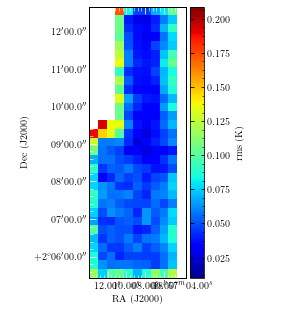

In [11]:
#plot rms
rms_out = rms_out.replace('.fits', '.pdf')

fig = plt.figure(figsize=(5,5))
ax = aplpy.FITSFigure(rms, figure=fig)
ax.show_colorscale(interpolation='nearest')

ax.set_nan_color('white')
ax.add_colorbar()
ax.colorbar.set_axis_label_text('rms (K)')
fig.savefig(rms_out, dpi=300, bbox_inches='tight')

INFO: Auto-setting vmax to  1.134e+01 [aplpy.core]


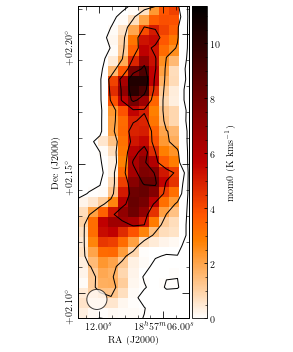

In [12]:
#plot mom0 with contours of signal-to-noise ratio for mom0
mom0_out = mom0_out.replace('.fits', '.pdf')

fig = plt.figure(figsize=(5,5))
ax = aplpy.FITSFigure(mom['mom0'].hdu, figure=fig)
ax.show_colorscale(interpolation='nearest', cmap='gist_heat_r', vmin=0)
ax.show_contour(s2n_hdu, colors='black', levels=[3,30,90,150], linewidths=1)

ax.add_colorbar()
ax.colorbar.set_axis_label_text('Integrated Intensity (K kms$^{-1}$)')

ax.add_beam()
ax.beam.set_alpha(0.75)
ax.beam.set_facecolor('white')
ax.beam.set_edgecolor('black')

ax.set_nan_color('white')
ax.ticks.set_xspacing(0.025)
ax.ticks.set_yspacing(0.05)
ax.ticks.set_color('black')
ax.tick_labels.set_xformat('dd.dd')
ax.tick_labels.set_yformat('dd.dd')

ax_ = fig.axes[0]
for tick in ax_.get_yticklabels():
    tick.set_rotation(90)

fig.tight_layout()
fig.savefig(mom0_out, dpi=300, bbox_inches='tight')